# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [17]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

  Using cached tensorflow-gpu-2.12.0.tar.gz (2.6 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Using cached opencv_python_headless-4.7.0.72-cp37-abi3-win_amd64.whl (38.1 MB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Running setup.py clean for tensorflow-gpu
Failed to build tensorflow-gpu
  Running setup.py install for tensorflow-gpu: started
  Running setup.py install for tensorflow-gpu: finished with status 'error'


  error: subprocess-exited-with-error
  
  python setup.py bdist_wheel did not run successfully.
  exit code: 1
  
  [18 lines of output]
  Traceback (most recent call last):
    File "<string>", line 2, in <module>
    File "<pip-setuptools-caller>", line 34, in <module>
    File "C:\Users\ok\AppData\Local\Temp\pip-install-9r4dcmwj\tensorflow-gpu_425dfb8a198349c4b4faceb131b5d8c2\setup.py", line 37, in <module>
      raise Exception(TF_REMOVAL_WARNING)
  Exception:
  
  The "tensorflow-gpu" package has been removed!
  
  Please install "tensorflow" instead.
  
  Other than the name, the two packages have been identical
  since TensorFlow 2.1, or roughly since Sep 2019. For more
  information, see: pypi.org/project/tensorflow-gpu
  
  
  [end of output]
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  ERROR: Failed building wheel for tensorflow-gpu
  error: subprocess-exited-with-error
  
  Running setup.py install for tensorflow-gpu did not ru

In [ ]:
pip uninstall opencv-python 

### 1.2 Collect Images Using OpenCV

In [1]:
import os
import time
import uuid
import cv2

In [2]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [3]:
cap = cv2.VideoCapture(0)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

NameError: name 'labelme' is not defined

In [11]:
pip install labelme

Note: you may need to restart the kernel to use updated packages.


In [1]:
!labelme

Traceback (most recent call last):
  File "D:\anaconda\lib\runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "D:\anaconda\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "D:\anaconda\Scripts\labelme.exe\__main__.py", line 4, in <module>
  File "D:\anaconda\lib\site-packages\labelme\__init__.py", line 17, in <module>
    QT4 = QT_VERSION[0] == "4"
TypeError: 'NoneType' object is not subscriptable


# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [4]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [5]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [6]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [15]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [16]:
images.as_numpy_iterator().next()

b'data\\images\\ae0e20ba-b60f-11ed-a2ea-dc4a3e602e6c.jpg'

In [17]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [18]:
images = images.map(load_image)

In [19]:

images.as_numpy_iterator().next()

array([[[98, 65, 74],
        [85, 52, 61],
        [89, 52, 60],
        ...,
        [20, 21, 25],
        [22, 23, 27],
        [22, 23, 27]],

       [[94, 61, 68],
        [85, 50, 57],
        [80, 45, 51],
        ...,
        [21, 22, 26],
        [20, 21, 25],
        [20, 21, 25]],

       [[91, 56, 60],
        [86, 52, 53],
        [80, 46, 45],
        ...,
        [23, 24, 26],
        [20, 21, 23],
        [21, 22, 24]],

       ...,

       [[20, 20, 22],
        [22, 22, 24],
        [24, 22, 25],
        ...,
        [17, 18, 20],
        [16, 17, 19],
        [16, 18, 17]],

       [[23, 22, 30],
        [24, 23, 31],
        [25, 22, 29],
        ...,
        [15, 16, 18],
        [15, 16, 18],
        [16, 18, 17]],

       [[31, 29, 40],
        [25, 23, 34],
        [22, 19, 28],
        ...,
        [15, 16, 18],
        [15, 16, 18],
        [17, 19, 18]]], dtype=uint8)

In [20]:
type(images)

tensorflow.python.data.ops.dataset_ops.MapDataset

### 2.4 View Raw Images with Matplotlib

In [21]:
image_generator = images.batch(4).as_numpy_iterator()

In [22]:
plot_images = image_generator.next()

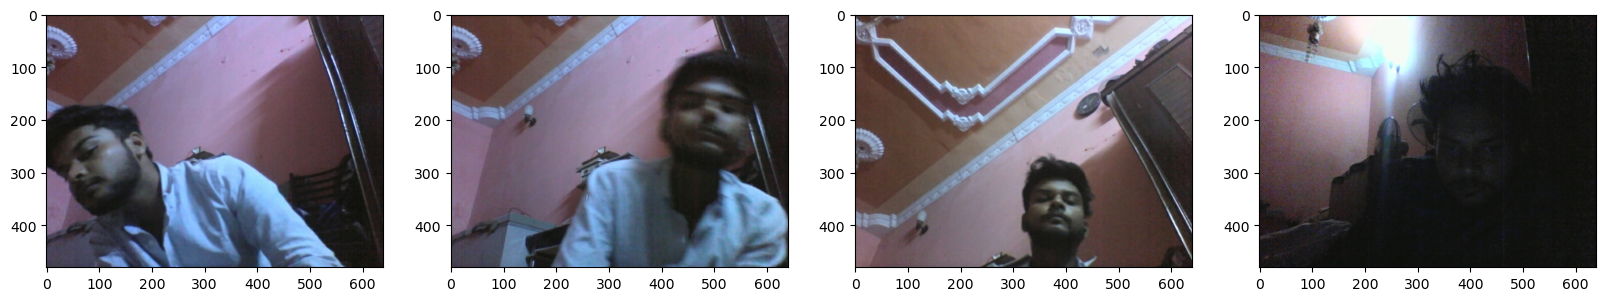

In [23]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [24]:
60*.7 # 42 to train

42.0

In [25]:
60*.15 # 9 and 9 to test and val

9.0

### 3.2 Move the Matching Labels

In [26]:
for folder in ['train','test','val']:
    for file in os.listdir(os.path.join('data', folder, 'images')):
        
        filename = file.split('.')[0]+'.json'
        existing_filepath = os.path.join('data','labels', filename)
        if os.path.exists(existing_filepath): 
            new_filepath = os.path.join('data',folder,'labels',filename)
            os.replace(existing_filepath, new_filepath)      

# 4. Apply Image Augmentation on Images and Labels using Albumentations

### 4.1 Setup Albumentations Transform Pipeline

In [22]:
pip install --user albumentations

  Using cached albumentations-1.3.0-py3-none-any.whl (123 kB)
  Using cached qudida-0.0.4-py3-none-any.whl (3.5 kB)
  Using cached opencv_python_headless-4.7.0.72-cp37-abi3-win_amd64.whl (38.1 MB)
Note: you may need to restart the kernel to use updated packages.


In [27]:
import albumentations as alb

In [28]:
img=cv2.imread(os.path.join('data','train','images','1f5e4e25-b610-11ed-9fa0-dc4a3e602e6c.jpg'))

In [29]:
img.shape

(480, 640, 3)

In [30]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [31]:
img = cv2.imread(os.path.join('data','train', 'images','1f5e4e25-b610-11ed-9fa0-dc4a3e602e6c.jpg'))

In [32]:
img

array([[[ 55,  56,  76],
        [ 48,  52,  71],
        [ 52,  56,  75],
        ...,
        [252, 246, 205],
        [252, 247, 208],
        [254, 249, 210]],

       [[ 56,  54,  76],
        [ 48,  49,  69],
        [ 47,  51,  70],
        ...,
        [252, 246, 203],
        [253, 249, 208],
        [255, 251, 210]],

       [[ 66,  62,  87],
        [ 62,  60,  82],
        [ 54,  57,  78],
        ...,
        [253, 250, 205],
        [255, 253, 205],
        [254, 252, 204]],

       ...,

       [[121, 102, 145],
        [114,  95, 138],
        [112,  93, 136],
        ...,
        [ 25,  24,  33],
        [ 24,  27,  32],
        [ 28,  31,  36]],

       [[124, 104, 146],
        [115,  95, 137],
        [113,  95, 136],
        ...,
        [ 24,  25,  29],
        [ 23,  27,  28],
        [ 27,  31,  32]],

       [[117,  98, 137],
        [112,  93, 132],
        [113,  95, 136],
        ...,
        [ 28,  30,  31],
        [ 25,  30,  29],
        [ 26,  31,  30]]

In [33]:
with open(os.path.join('data', 'train', 'labels', '1ea602ee-b610-11ed-9438-dc4a3e602e6c.json'), 'r') as f:
    label = json.load(f)

In [34]:
label['shapes'][0]['points']

[[256.95652173913044, 162.60869565217394],
 [449.1304347826087, 441.73913043478257]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [35]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [36]:
coords

[256.95652173913044, 162.60869565217394, 449.1304347826087, 441.73913043478257]

In [37]:
coords = list(np.divide(coords, [640,480,640,480]))

In [38]:
coords

[0.4014945652173913,
 0.33876811594202905,
 0.701766304347826,
 0.9202898550724636]

### 4.4 Apply Augmentations and View Results

In [39]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])

In [40]:
augmented['bboxes'][0][2:]

(0.7558454106280194, 0.9194202898550724)

In [41]:
augmented['bboxes']

[(0.328792270531401,
  0.29913043478260876,
  0.7558454106280194,
  0.9194202898550724)]

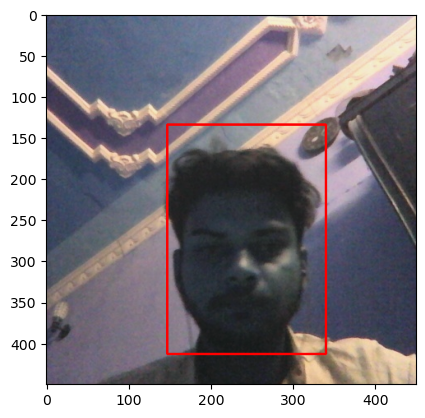

In [42]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [43]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(60):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['face'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [44]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [45]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [46]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [47]:
train_images.as_numpy_iterator().next()

array([[[0.3622549 , 0.28039217, 0.2254902 ],
        [0.3509804 , 0.27922794, 0.21501225],
        [0.36550245, 0.2954044 , 0.23658088],
        ...,
        [0.7428309 , 0.73284316, 0.8151961 ],
        [0.7499387 , 0.75324756, 0.8238358 ],
        [0.7612745 , 0.7608456 , 0.8297794 ]],

       [[0.3889093 , 0.29773283, 0.27058825],
        [0.36936274, 0.29240197, 0.26642156],
        [0.39889705, 0.33112746, 0.29436275],
        ...,
        [0.7490196 , 0.75306374, 0.83186275],
        [0.7352941 , 0.7466299 , 0.8054534 ],
        [0.7458946 , 0.75667894, 0.8110907 ]],

       [[0.4165441 , 0.3134191 , 0.31691176],
        [0.3791054 , 0.2771446 , 0.28106618],
        [0.39074755, 0.2956495 , 0.28743872],
        ...,
        [0.7411765 , 0.7607843 , 0.8469363 ],
        [0.75147057, 0.7642157 , 0.8391544 ],
        [0.75582105, 0.75582105, 0.828799  ]],

       ...,

       [[0.40355393, 0.29375   , 0.35208333],
        [0.41219363, 0.30735293, 0.37395832],
        [0.3935662 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [48]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [49]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [50]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [51]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [52]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.44  , 0.2969, 0.867 , 0.917 ], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [53]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(2520, 2520, 540, 540, 540, 540)

### 7.2 Create Final Datasets (Images/Labels)

In [54]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [55]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [56]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [57]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.01275, 0.     , 0.3816 , 0.4292 ],
        [0.54   , 0.1765 , 0.9473 , 0.7144 ],
        [0.3667 , 0.1609 , 0.774  , 0.699  ],
        [0.     , 0.09827, 0.2954 , 0.935  ],
        [0.3054 , 0.01567, 0.732  , 0.5537 ],
        [0.04312, 0.2048 , 0.4333 , 0.7236 ],
        [0.3347 , 0.2607 , 0.727  , 0.8022 ],
        [0.2242 , 0.5635 , 0.6846 , 1.     ]], dtype=float16))

### 7.3 View Images and Annotations

In [58]:
data_samples = train.as_numpy_iterator()

In [59]:
res = data_samples.next()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


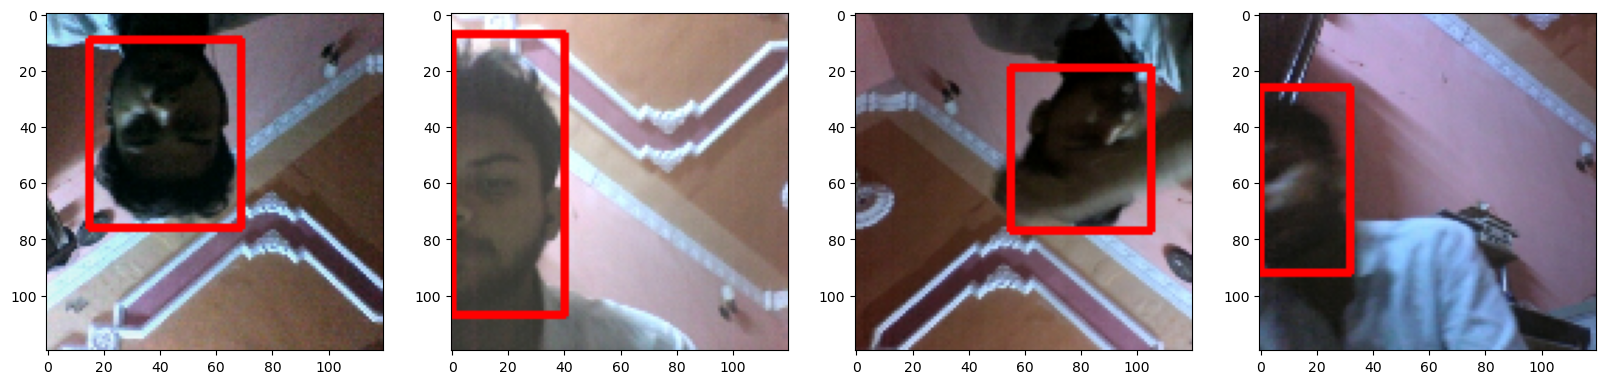

In [60]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = res[0][idx]
    sample_coords = res[1][1][idx]
    
    cv2.rectangle(sample_image, 
                  tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                  tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                        (255,0,0), 2)

    ax[idx].imshow(sample_image)

# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [61]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [62]:
vgg = VGG16(include_top=False)

In [63]:
vgg.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, None, 3)]   0         
                                                                 
 block1_conv1 (Conv2D)       (None, None, None, 64)    1792      
                                                                 
 block1_conv2 (Conv2D)       (None, None, None, 64)    36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, None, None, 64)    0         
                                                                 
 block2_conv1 (Conv2D)       (None, None, None, 128)   73856     
                                                                 
 block2_conv2 (Conv2D)       (None, None, None, 128)   147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, None, None, 128)   0     

### 8.3 Build instance of Network

In [64]:
def build_model(): 
    input_layer = Input(shape=(120,120,3))
    
    vgg = VGG16(include_top=False)(input_layer)

    # Classification Model  
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    
    # Bounding box model
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    facetracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return facetracker

### 8.4 Test out Neural Network

In [65]:
facetracker = build_model()

In [66]:
facetracker.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 vgg16 (Functional)             (None, None, None,   14714688    ['input_2[0][0]']                
                                512)                                                              
                                                                                                  
 global_max_pooling2d (GlobalMa  (None, 512)         0           ['vgg16[0][0]']                  
 xPooling2D)                                                                                  

In [67]:
X, y = train.as_numpy_iterator().next()

In [68]:
X.shape

(8, 120, 120, 3)

In [69]:
classes, coords = facetracker.predict(X)

1/1 [==============================] - 5s 5s/step


In [70]:
classes, coords

(array([[0.38911772],
        [0.46966836],
        [0.54926026],
        [0.46514192],
        [0.48050463],
        [0.48303625],
        [0.4841604 ],
        [0.53962225]], dtype=float32),
 array([[0.45714378, 0.4664062 , 0.40306938, 0.52991194],
        [0.46188837, 0.3816513 , 0.3519968 , 0.6020401 ],
        [0.57999396, 0.3154949 , 0.35963848, 0.59497774],
        [0.32001194, 0.3573799 , 0.39485788, 0.51544225],
        [0.45636314, 0.39718705, 0.3211517 , 0.6094732 ],
        [0.35736248, 0.44720882, 0.4801827 , 0.60712045],
        [0.42578003, 0.32813278, 0.39134297, 0.61915046],
        [0.4440642 , 0.34826386, 0.4838821 , 0.63075626]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [71]:
batches_per_epoch = len(train)
lr_decay = (1./0.75 -1)/batches_per_epoch

In [72]:
opt = tf.keras.optimizers.legacy.Adam(learning_rate=0.0001, decay=lr_decay)

### 9.2 Create Localization Loss and Classification Loss

In [73]:
def localization_loss(y_true, yhat):            
    delta_coord = tf.reduce_sum(tf.square(y_true[:,:2] - yhat[:,:2]))
                  
    h_true = y_true[:,3] - y_true[:,1] 
    w_true = y_true[:,2] - y_true[:,0] 

    h_pred = yhat[:,3] - yhat[:,1] 
    w_pred = yhat[:,2] - yhat[:,0] 
    
    delta_size = tf.reduce_sum(tf.square(w_true - w_pred) + tf.square(h_true-h_pred))
    
    return delta_coord + delta_size

In [74]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [75]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.5205355>

In [76]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.7333753>

In [77]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=3.5205355>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [78]:
class FaceTracker(Model): 
    def __init__(self, eyetracker,  **kwargs): 
        super().__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super().compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss+0.5*batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
        
        opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss+0.5*batch_classloss
        
        return {"total_loss":total_loss, "class_loss":batch_classloss, "regress_loss":batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)

In [79]:
model = FaceTracker(facetracker)

In [80]:
model.compile(opt, classloss, regressloss)

### 10.2 Train

In [81]:
logdir='logs'

In [82]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [83]:
hist = model.fit(train, epochs=5, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/5
315/315 [==============================] - 1186s 4s/step - total_loss: 0.3964 - class_loss: 0.0766 - regress_loss: 0.3581 - val_total_loss: 0.1122 - val_class_loss: 6.7311e-05 - val_regress_loss: 0.1122
Epoch 2/5
315/315 [==============================] - 1157s 4s/step - total_loss: 0.1550 - class_loss: 0.0398 - regress_loss: 0.1350 - val_total_loss: 0.0890 - val_class_loss: 3.2222e-04 - val_regress_loss: 0.0889
Epoch 3/5
315/315 [==============================] - 1155s 4s/step - total_loss: 0.0888 - class_loss: 0.0276 - regress_loss: 0.0749 - val_total_loss: 0.7706 - val_class_loss: 0.7843 - val_regress_loss: 0.3785
Epoch 4/5
315/315 [==============================] - 20106s 64s/step - total_loss: 0.0769 - class_loss: 0.0228 - regress_loss: 0.0655 - val_total_loss: 0.0435 - val_class_loss: 0.0014 - val_regress_loss: 0.0428
Epoch 5/5
315/315 [==============================] - 1136s 3s/step - total_loss: 0.0575 - class_loss: 0.0156 - regress_loss: 0.0497 - val_total_loss: 0.09

### 10.3 Plot Performance

In [84]:
hist.history

{'total_loss': [0.11418981105089188,
  0.41869503259658813,
  0.013724735006690025,
  0.01716504618525505,
  0.7060903906822205],
 'class_loss': [0.001530221663415432,
  0.09424679726362228,
  0.00016379157023038715,
  0.00037962000351399183,
  0.15010930597782135],
 'regress_loss': [0.11342470347881317,
  0.3715716302394867,
  0.013642839156091213,
  0.01697523705661297,
  0.6310357451438904],
 'val_total_loss': [0.11223548650741577,
  0.08901315927505493,
  0.7706006765365601,
  0.04348446801304817,
  0.09400778263807297],
 'val_class_loss': [6.731120083713904e-05,
  0.0003222181985620409,
  0.7842578291893005,
  0.0013701466377824545,
  9.109044185606763e-05],
 'val_regress_loss': [0.11220183223485947,
  0.08885204792022705,
  0.3784717917442322,
  0.04279939457774162,
  0.09396223723888397]}

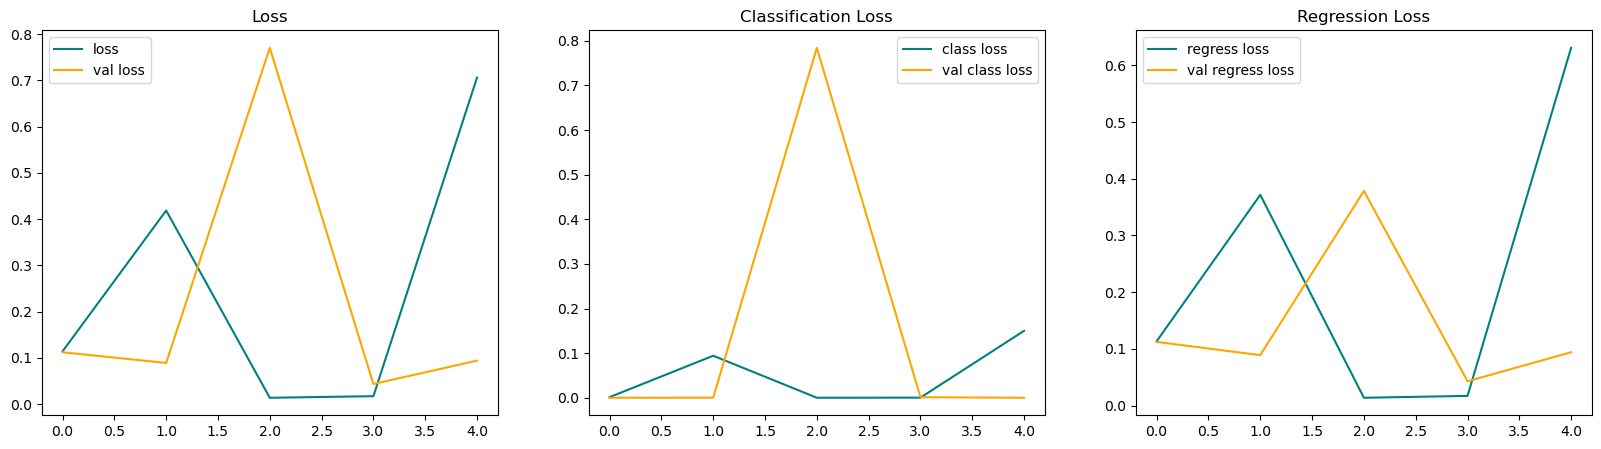

In [85]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [86]:
test_data = test.as_numpy_iterator()

In [87]:
test_sample = test_data.next()

In [88]:
yhat = facetracker.predict(test_sample[0])

1/1 [==============================] - 1s 1s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


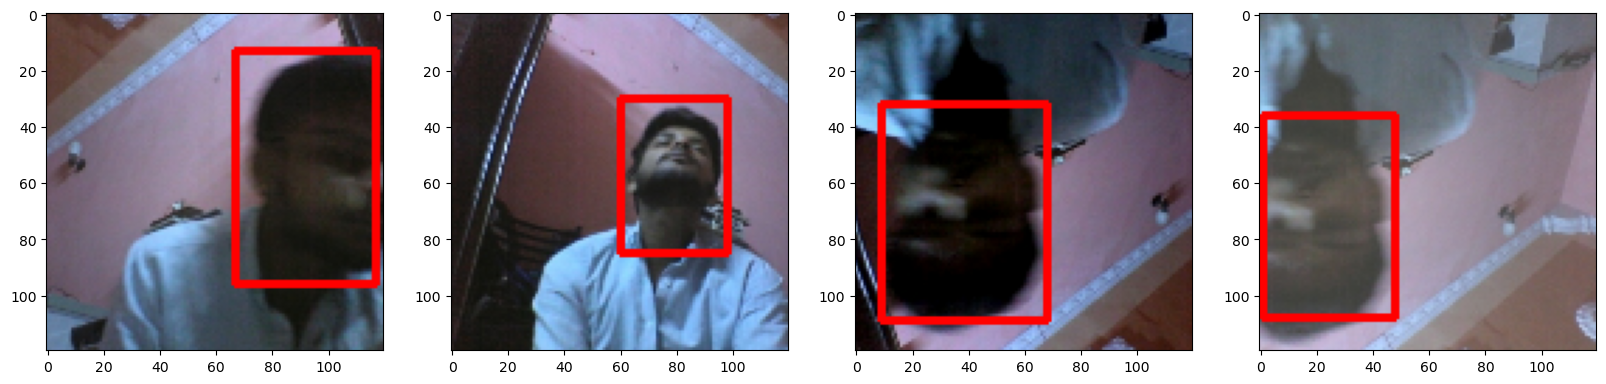

In [89]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx in range(4): 
    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]
    
    if yhat[0][idx] > 0.9:
        cv2.rectangle(sample_image, 
                      tuple(np.multiply(sample_coords[:2], [120,120]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [120,120]).astype(int)), 
                            (255,0,0), 2)
    
    ax[idx].imshow(sample_image)

### 11.2 Save the Model

In [90]:
from tensorflow.keras.models import load_model

In [91]:
facetracker.save('facetracker.h5')

In [92]:
facetracker = load_model('facetracker.h5')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500, :]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = facetracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        # Controls the main rectangle
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        # Controls the label rectangle
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        # Controls the text rendered
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('FaceTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

1/1 [==============================] - 0s 202ms/step
